In [ ]:
#imports
from DLStudio import DLStudio

import sys,os,os.path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision                  
import torchvision.transforms as tvt
import torchvision.transforms.functional as tvtF
import torch.optim as optim
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import glob                                                                                                           
import imageio 
import matplotlib.image as mpimg

In [26]:
#Inherited the DLStudio class for implementing the GAN model class including the Generator and Discriminator network
# and the Run training routine code
# The code is inspired from Dr. Avinash Kak's DL Studio Module AdversarialLearning class

                                                                                                    
class GAN(object):
    
    def __init__(self, *args, **kwargs ):
        if args:
            raise ValueError(  
                   '''GAN constructor can only be called with keyword arguments for the following
                      keywords: epochs, learning_rate, batch_size, momentum, image_size, dataroot, path_saved_model, 
                      use_gpu, latent_vector_size, ngpu, dlstudio, device, LAMBDA, clipping_threshold, and beta1''')
        allowed_keys = 'dataroot','image_size','path_saved_model','momentum','learning_rate','epochs','batch_size', \
                       'classes','use_gpu','latent_vector_size','ngpu','dlstudio', 'beta1', 'LAMBDA', 'clipping_threshold'
        keywords_used = kwargs.keys()                                                                 
        for keyword in keywords_used:                                                                 
            if keyword not in allowed_keys:                                                           
                raise SyntaxError(keyword + ":  Wrong keyword used --- check spelling")  
        learning_rate = epochs = batch_size = convo_layers_config = momentum = None
        image_size = fc_layers_config = dataroot =  path_saved_model = classes = use_gpu = None
        latent_vector_size = ngpu = beta1 = LAMBDA = clipping_threshold = None
        if 'latent_vector_size' in kwargs            :   latent_vector_size = kwargs.pop('latent_vector_size')
        if 'ngpu' in kwargs                          :   ngpu  = kwargs.pop('ngpu')           
        if 'dlstudio' in kwargs                      :   dlstudio  = kwargs.pop('dlstudio')
        if 'beta1' in kwargs                         :   beta1  = kwargs.pop('beta1')
        if 'LAMBDA' in kwargs                        :   LAMBDA  = kwargs.pop('LAMBDA')
        if 'clipping_threshold' in kwargs            :   clipping_threshold = kwargs.pop('clipping_threshold')
        if latent_vector_size:
            self.latent_vector_size = latent_vector_size
        if ngpu:
            self.ngpu = ngpu
        if dlstudio:
            self.dlstudio = dlstudio
        if beta1:
            self.beta1 = beta1
        if LAMBDA:
            self.LAMBDA = LAMBDA
        if clipping_threshold:
            self.clipping_threshold = clipping_threshold 


    class DataModeling(nn.Module):             
     
        def __init__(self, dlstudio, adversarial, num_workers=2):
            super().__init__()
            self.dlstudio = dlstudio
            self.adversarial  = adversarial
            self.num_workers = num_workers
            self.train_dataloader = None
            self.device = torch.device("cuda:0" if (torch.cuda.is_available() and adversarial.ngpu > 0) else "cpu")
        
        def show_sample_images_from_dataset(self, dlstudio):
            data = next(iter(self.train_dataloader))    
            real_batch = data[0]
            self.dlstudio.display_tensor_as_image(torchvision.utils.make_grid(real_batch, padding=2, pad_value=1, normalize=True))

        def set_dataloader(self):
            dataset = torchvision.datasets.ImageFolder(root=self.dlstudio.dataroot,       
                           transform = tvt.Compose([                 
                                                tvt.Resize(self.dlstudio.image_size),             
                                                tvt.CenterCrop(self.dlstudio.image_size),         
                                                tvt.ToTensor(),                     
                                                tvt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),         
                           ]))
            self.train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.dlstudio.batch_size, 
                                                                                     shuffle=True, num_workers=self.num_workers)


        def weights_init(self,m):        
            classname = m.__class__.__name__     
            if classname.find('Conv') != -1:         
                nn.init.normal_(m.weight.data, 0.0, 0.02)      
            elif classname.find('BatchNorm') != -1:         
                nn.init.normal_(m.weight.data, 1.0, 0.02)       
                nn.init.constant_(m.bias.data, 0) 

        class Discriminator(nn.Module):

            def __init__(self):
                super().__init__()
                self.conv_in = nn.Conv2d(  3,    64,      kernel_size=4,      stride=2,    padding=1)
                self.conv_in2 = nn.Conv2d( 64,   128,     kernel_size=4,      stride=2,    padding=1)
                self.conv_in3 = nn.Conv2d( 128,  256,     kernel_size=4,      stride=2,    padding=1)
                self.conv_in4 = nn.Conv2d( 256,  512,     kernel_size=4,      stride=2,    padding=1)
                self.conv_in5 = nn.Conv2d( 512,  1,       kernel_size=4,      stride=1,    padding=0)
                self.bn1  = nn.BatchNorm2d(128)
                self.bn2  = nn.BatchNorm2d(256)
                self.bn3  = nn.BatchNorm2d(512)
                self.sig = nn.Sigmoid()
            def forward(self, x):                 
                x = torch.nn.functional.leaky_relu(self.conv_in(x), negative_slope=0.2, inplace=True)
                x = self.bn1(self.conv_in2(x))
                x = torch.nn.functional.leaky_relu(x, negative_slope=0.2, inplace=True)
                x = self.bn2(self.conv_in3(x))
                x = torch.nn.functional.leaky_relu(x, negative_slope=0.2, inplace=True)
                x = self.bn3(self.conv_in4(x))
                x = torch.nn.functional.leaky_relu(x, negative_slope=0.2, inplace=True)
                x = self.conv_in5(x)
                x = self.sig(x)
                return x

        class Generator(nn.Module):

            def __init__(self):
                super().__init__()
                self.latent_to_image = nn.ConvTranspose2d( 100,   512,  kernel_size=4, stride=1, padding=0, bias=False)
                self.upsampler2 = nn.ConvTranspose2d( 512, 256, kernel_size=4, stride=2, padding=1, bias=False)
                self.upsampler3 = nn.ConvTranspose2d (256, 128, kernel_size=4, stride=2, padding=1, bias=False)
                self.upsampler4 = nn.ConvTranspose2d (128, 64,  kernel_size=4, stride=2, padding=1, bias=False)
                self.upsampler5 = nn.ConvTranspose2d(  64,  3,  kernel_size=4, stride=2, padding=1, bias=False)
                self.bn1 = nn.BatchNorm2d(512)
                self.bn2 = nn.BatchNorm2d(256)
                self.bn3 = nn.BatchNorm2d(128)
                self.bn4 = nn.BatchNorm2d(64)
                self.tanh  = nn.Tanh()
            def forward(self, x):                     
                x = self.latent_to_image(x)
                x = torch.nn.functional.relu(self.bn1(x))
                x = self.upsampler2(x)
                x = torch.nn.functional.relu(self.bn2(x))
                x = self.upsampler3(x)
                x = torch.nn.functional.relu(self.bn3(x))
                x = self.upsampler4(x)
                x = torch.nn.functional.relu(self.bn4(x))
                x = self.upsampler5(x)
                x = self.tanh(x)
                return x
     


    #running training loop logic is taken from DL Studio code by Dr. Kak with slight modification to save the generator model after training      
        def training_routine(self, dlstudio, adversarial, discriminator, generator, results_dir):
           
            dir_name_for_results = results_dir
            if os.path.exists(dir_name_for_results):
                files = glob.glob(dir_name_for_results + "/*")
                for file in files:
                    if os.path.isfile(file):
                        os.remove(file)
                    else:
                        files = glob.glob(file + "/*")
                        list(map(lambda x: os.remove(x), files))
            else:
                os.mkdir(dir_name_for_results)
            #  Set the number of channels for the 1x1 input noise vectors for the Generator:
            nz = 100
            netD = discriminator.to(self.device)
            netG = generator.to(self.device)
            #  Initialize the parameters of the Discriminator and the Generator networks according to the
            #  definition of the "weights_init()" method:
            netD.apply(self.weights_init)
            netG.apply(self.weights_init)
            #  We will use a the same noise batch to periodically check on the progress made for the Generator:
            fixed_noise = torch.randn(self.dlstudio.batch_size, nz, 1, 1, device=self.device)          
            #  Establish convention for real and fake labels during training
            real_label = 1   
            fake_label = 0         
            #  Adam optimizers for the Discriminator and the Generator:
            optimizerD = optim.Adam(netD.parameters(), lr=dlstudio.learning_rate, betas=(adversarial.beta1, 0.999))    
            optimizerG = optim.Adam(netG.parameters(), lr=dlstudio.learning_rate, betas=(adversarial.beta1, 0.999))
            #  Establish the criterion for measuring the loss at the output of the Discriminator network:
            criterion = nn.BCELoss()
            #  We will use these lists to store the results accumulated during training:
            img_list = []                               
            G_losses = []                               
            D_losses = []                               
            iters = 0                                   
            print("\n\nStarting Training Loop...\n\n")      
            start_time = time.perf_counter()            
            for epoch in range(dlstudio.epochs):        
                g_losses_per_print_cycle = []           
                d_losses_per_print_cycle = []           
                # For each batch in the dataloader
                for i, data in enumerate(self.train_dataloader, 0):         

                    ##  Maximization Part of the Min-Max Objective of Eq. (3):
                    ##
                    ##  As indicated by Eq. (3) in the DCGAN part of the doc section at the beginning of this 
                    ##  file, the GAN training boils down to carrying out a min-max optimization. Each iterative 
                    ##  step of the max part results in updating the Discriminator parameters and each iterative 
                    ##  step of the min part results in the updating of the Generator parameters.  For each 
                    ##  batch of the training data, we first do max and then do min.  Since the max operation 
                    ##  affects both terms of the criterion shown in the doc section, it has two parts: In the
                    ##  first part we apply the Discriminator to the training images using 1.0 as the target; 
                    ##  and, in the second part, we supply to the Discriminator the output of the Generator 
                    ##  and use 0 as the target. In what follows, the Discriminator is being applied to 
                    ##  the training images:
                    netD.zero_grad()    
                    real_images_in_batch = data[0].to(self.device)     
                    #  Need to know how many images we pulled in since at the tailend of the dataset, the 
                    #  number of images may not equal the user-specified batch size:
                    b_size = real_images_in_batch.size(0)  
                    label = torch.full((b_size,), real_label, dtype=torch.float, device=self.device)  
                    output = netD(real_images_in_batch).view(-1)  
                    lossD_for_reals = criterion(output, label)                                                   
                    lossD_for_reals.backward()                                                                   
                    ##  That brings us the second part of what it takes to carry out the max operation on the
                    ##  min-max criterion shown in Eq. (3) in the doc section at the beginning of this file.
                    ##  part calls for applying the Discriminator to the images produced by the Generator from 
                    ##  noise:
                    noise = torch.randn(b_size, nz, 1, 1, device=self.device)    
                    fakes = netG(noise) 
                    label.fill_(fake_label) 
                    ##  The call to fakes.detach() in the next statement returns a copy of the 'fakes' tensor 
                    ##  that does not exist in the computational graph. That is, the call shown below first 
                    ##  makes a copy of the 'fakes' tensor and then removes it from the computational graph. 
                    ##  The original 'fakes' tensor continues to remain in the computational graph.  This ploy 
                    ##  ensures that a subsequent call to backward() in the 3rd statement below would only
                    ##  update the netD weights.
                    output = netD(fakes.detach()).view(-1)    
                    lossD_for_fakes = criterion(output, label)    
                    ##  At this point, we do not care if the following call also calculates the gradients
                    ##  wrt the Discriminator weights since we are going to next iteration with 'netD.zero_grad()':
                    lossD_for_fakes.backward()          
                    lossD = lossD_for_reals + lossD_for_fakes    
                    d_losses_per_print_cycle.append(lossD)  
                    ##  Only the Discriminator weights are incremented:
                    optimizerD.step()  

                    ##  Minimization Part of the Min-Max Objective of Eq. (3):
                    ##
                    ##  That brings to the min part of the max-min optimization described in Eq. (3) the doc 
                    ##  section at the beginning of this file.  The min part requires that we minimize 
                    ##  "1 - D(G(z))" which, since D is constrained to lie in the interval (0,1), requires that 
                    ##  we maximize D(G(z)).  We accomplish that by applying the Discriminator to the output 
                    ##  of the Generator and use 1 as the target for each image:
                    netG.zero_grad()   
                    label.fill_(real_label)  
                    output = netD(fakes).view(-1)   
                    lossG = criterion(output, label)          
                    g_losses_per_print_cycle.append(lossG) 
                    lossG.backward()    
                    ##  Only the Generator parameters are incremented:
                    optimizerG.step() 
                    if i % 100 == 99:                                                                           
                        current_time = time.perf_counter()                                                      
                        elapsed_time = current_time - start_time                                                
                        mean_D_loss = torch.mean(torch.FloatTensor(d_losses_per_print_cycle))                   
                        mean_G_loss = torch.mean(torch.FloatTensor(g_losses_per_print_cycle))                   
                        print("[epoch=%d/%d   iter=%4d   elapsed_time=%5d secs]     mean_D_loss=%7.4f    mean_G_loss=%7.4f" % 
                                      ((epoch+1),dlstudio.epochs,(i+1),elapsed_time,mean_D_loss,mean_G_loss))   
                        d_losses_per_print_cycle = []                                                           
                        g_losses_per_print_cycle = []                                                           
                    G_losses.append(lossG.item())                                                                
                    D_losses.append(lossD.item())                                                                
                    if (iters % 500 == 0) or ((epoch == dlstudio.epochs-1) and (i == len(self.train_dataloader)-1)):   
                        with torch.no_grad():             
                            fake = netG(fixed_noise).detach().cpu()  ## detach() removes the fake from comp. graph. 
                                                                     ## for creating its CPU compatible version
                        img_list.append(torchvision.utils.make_grid(fake, padding=1, pad_value=1, normalize=True))
                    iters += 1 
   
            torch.save(netG.state_dict(), os.path.join(results_dir,"generator.pt")) # save the generator trained model to later use
                                                                      #for generating fake images from noise.

            #  At the end of training, make plots from the data in G_losses and D_losses:
            plt.figure(figsize=(10,5))    
            plt.title("Generator and Discriminator Loss During Training for 30 epochs")    
            plt.plot(G_losses,label="Generator")    
            plt.plot(D_losses,label="Discriminator") 
            plt.xlabel("iterations")   
            plt.ylabel("Loss")         
            plt.legend()          
            plt.savefig(dir_name_for_results + "/gen_and_disc_loss_training.png") 
            plt.show()    
            
            #  Make a side-by-side comparison of a batch-size sampling of real images drawn from the
            #  training data and what the Generator is capable of producing at the end of training:
            real_batch = next(iter(self.train_dataloader)) 
            real_batch = real_batch[0]
            plt.figure(figsize=(15,15))  
            plt.subplot(1,2,1)   
            plt.axis("off")   
            plt.title("Real Images")    
            plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch.to(self.device), 
                                                   padding=1, pad_value=1, normalize=True).cpu(),(1,2,0)))  
            plt.subplot(1,2,2)                                                                             
            plt.axis("off")                                                                                
            plt.title("Fake Images")                                                                       
            plt.imshow(np.transpose(img_list[-1],(1,2,0)))                                                 
            plt.savefig(dir_name_for_results + "/real_vs_fake_images.png")                                 
            plt.show()                                                                                     





The number of learnable parameters in the Discriminator: 2766529


The number of learnable parameters in the Generator: 3576704


The number of layers in the discriminator: 16


The number of layers in the generator: 13




Here is one batch of images from the training dataset:


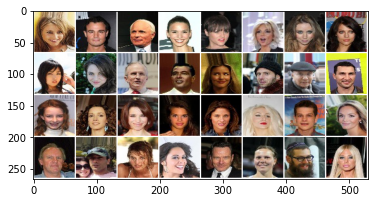



Starting Training Loop...


[epoch=1/30   iter= 100   elapsed_time=    1 secs]     mean_D_loss= 0.0714    mean_G_loss= 6.9633
[epoch=1/30   iter= 200   elapsed_time=    2 secs]     mean_D_loss= 0.0175    mean_G_loss= 9.4740
[epoch=1/30   iter= 300   elapsed_time=    3 secs]     mean_D_loss= 0.3668    mean_G_loss=23.2490
[epoch=2/30   iter= 100   elapsed_time=    4 secs]     mean_D_loss= 0.4137    mean_G_loss= 6.5238
[epoch=2/30   iter= 200   elapsed_time=    5 secs]     mean_D_loss= 0.5258    mean_G_loss= 5.1912
[epoch=2/30   iter= 300   elapsed_time=    6 secs]     mean_D_loss= 0.5279    mean_G_loss= 4.6272
[epoch=3/30   iter= 100   elapsed_time=    8 secs]     mean_D_loss= 0.6398    mean_G_loss= 4.6506
[epoch=3/30   iter= 200   elapsed_time=    9 secs]     mean_D_loss= 0.6334    mean_G_loss= 4.3690
[epoch=3/30   iter= 300   elapsed_time=   10 secs]     mean_D_loss= 0.4941    mean_G_loss= 4.2807
[epoch=4/30   iter= 100   elapsed_time=   11 secs]     mean_D_loss= 0.5733    mean_G_los

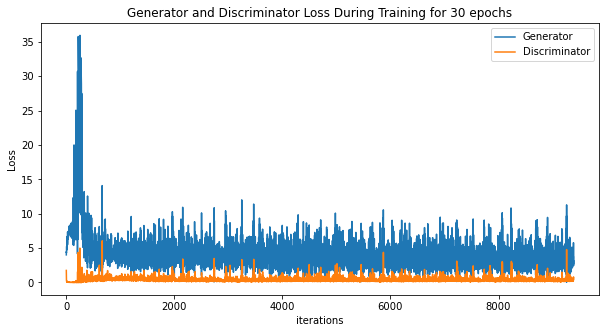

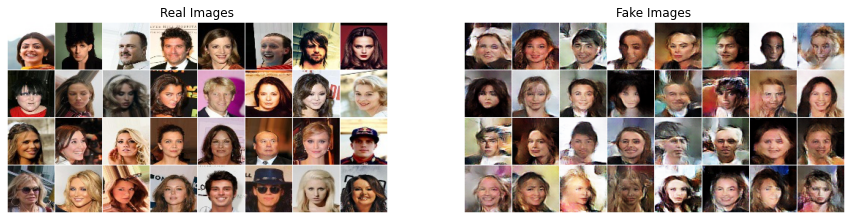

In [27]:
#Code for running the training routine for GAN model for 30 epochs
# The code is inspired from Dr. Avinash Kak's DL Studio Module 

seed = 0           
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmarks=False
os.environ['PYTHONHASHSEED'] = str(seed)


from DLStudio import *


import sys

dls = DLStudio(                                                                                       
                  dataroot = "./celebA/", 
                  image_size = [64,64],                                                               
                  path_saved_model = "./saved_model_GAN_CelebA", 
                  learning_rate = 1e-4,      
                  epochs = 30,
                  batch_size = 32,                                                                     
                  use_gpu = True,                                                                     
              )           

gan = GAN(
                  dlstudio = dls,
                  ngpu = 1,    
                  latent_vector_size = 100,
                  beta1 = 0.5,                          
              )

dcgan =   GAN.DataModeling( dlstudio = dls, adversarial = gan )

device=torch.device("cuda:0" if (torch.cuda.is_available() and gan.ngpu > 0) else "cpu")

discriminator =  dcgan.Discriminator()
generator =  dcgan.Generator()

num_learnable_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print("\n\nThe number of learnable parameters in the Discriminator: %d\n" % num_learnable_params_disc)
num_learnable_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
print("\nThe number of learnable parameters in the Generator: %d\n" % num_learnable_params_gen)
num_layers_disc = len(list(discriminator.parameters()))
print("\nThe number of layers in the discriminator: %d\n" % num_layers_disc)
num_layers_gen = len(list(generator.parameters()))
print("\nThe number of layers in the generator: %d\n\n" % num_layers_gen)

dcgan.set_dataloader()

print("\n\nHere is one batch of images from the training dataset:")
dcgan.show_sample_images_from_dataset(dls)

dcgan.training_routine(dls, gan, discriminator=discriminator, generator=generator, results_dir="results_DG12")

In [28]:
# generating 2048 fake images from randomly sampled noise vectors using  trained generator BCE-GAN
generator.load_state_dict(torch.load("./results_DG12/generator.pt"))
# directory to store the generated fake images
fake_images_dir = os.path.join("results_DG12", "fake_images")
os.makedirs(fake_images_dir, exist_ok=True)
num_fake_images = 2048
with torch.no_grad():
    for i in range(num_fake_images):
        # Generate a noise vector
        noise = torch.randn(1, 100, 1, 1, device=device)

        # Generate a fake image from the noise vector
        fake = generator(noise).detach().cpu()

        # Save the fake image
        fake_image_path = os.path.join(fake_images_dir, f"fake_image_{i}.png")
        torchvision.utils.save_image(fake, fake_image_path)

print(f"{num_fake_images} fake images saved at:", fake_images_dir)

2048 fake images saved at: results_DG12/fake_images


In [29]:
#Code to calculate FID score for BCE GAN generated images
#This code has been used from the code provided in the homework 8 document

#install pytorch-fid package
!pip install pytorch-fid
from pytorch_fid.fid_score import calculate_activation_statistics , calculate_frechet_distance
from pytorch_fid.inception import InceptionV3

# script to populate the real and fake image path lists

real_dir = "./celebA/0/"
fake_dir = "./results_DG12/fake_images/"

# Getting the list of image files in the directories
real_paths = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if os.path.isfile(os.path.join(real_dir, f))]
fake_paths = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if os.path.isfile(os.path.join(fake_dir, f))]

dims = 2048
block_idx = InceptionV3 . BLOCK_INDEX_BY_DIM [ dims ]
model = InceptionV3 ([ block_idx ]) . to ( device )
m1 , s1 = calculate_activation_statistics (real_paths , model , device = device )
m2 , s2 = calculate_activation_statistics (fake_paths , model , device = device )
fid_value = calculate_frechet_distance ( m1 , s1 , m2 , s2 )
print ( f"FID: { fid_value : .2f}")

100%|██████████| 41/41 [00:02<00:00, 15.84it/s]


FID:  120.15


In [ ]:
#Code for generating fake images by diffusion model using the weights provided in the trained model "diffusion.pt" file.
# The code is derived from Dr. Avinash Kak's DL Studio Module 

from GenerativeDiffusion import *

gauss_diffusion   =  GaussianDiffusion(
                        num_diffusion_timesteps = 1000,

                    )


network =  UNetModel(
                       in_channels=3,
                       model_channels   =  128,
                       out_channels     =  3,
                       num_res_blocks   =  2,
                       attention_resolutions =  (4, 8),       
                       channel_mult     =    (1, 2, 3, 4),          
                       num_heads        =    1,
                       attention        =    True           
                     )


top_level = GenerativeDiffusion(
                        gen_new_images        =        True,
                        image_size            =        64,
                        num_channels          =        128,
                        ema_rate              =        0.9999,
                        diffusion = gauss_diffusion,
                        network = network,
                        ngpu = 1,
                        path_saved_model = "RESULTS_celebA",
                        clip_denoised=True,
                        num_samples=2048, 
                        batch_size_image_generation=8,
             )   


model_path = "./diffusion.pt"


network.load_state_dict( torch.load(model_path) )

network.to(top_level.device)
network.eval()

print("sampling...")
all_images = []

while len(all_images) * top_level.batch_size_image_generation < top_level.num_samples:
    sample = gauss_diffusion.p_sampler_for_image_generation(
        network,
        (top_level.batch_size_image_generation, 3, top_level.image_size, top_level.image_size),
        device = top_level.device,
        clip_denoised = top_level.clip_denoised,
    )
    sample = ((sample + 1) * 127.5).clamp(0, 255).to(torch.uint8)
    sample = sample.permute(0, 2, 3, 1)
    sample = sample.contiguous()
    gathered_samples = [sample]
    all_images.extend([sample.cpu().numpy() for sample in gathered_samples])
    print(f"created {len(all_images) * top_level.batch_size_image_generation} samples")

arr = np.concatenate(all_images, axis=0)
arr = arr[: top_level.num_samples]

shape_str = "x".join([str(x) for x in arr.shape])
out_path = os.path.join(top_level.path_saved_model, f"samples_{shape_str}.npz")

np.savez(out_path, arr)

print("image generation completed")


In [ ]:
#Code for visualizing and saving the fake images generated using the .npz file above
# The code is derived from Dr. Avinash Kak's DL Studio Module 

print("\n\nPutting together a collage of the generated images for display\n")
print("\nFor the individual images, check the directory 'visualize_samples'\n\n")


npz_archive = "RESULTS_celebA/samples_2048x64x64x3.npz"        
visualization_dir  =  "visualize_samples_celebA12"
image_display_size = (64,64)


if os.path.exists(visualization_dir):
    files = glob.glob(visualization_dir + "/*")
    for file in files:
        if os.path.isfile(file):
            os.remove(file)
else:
    os.mkdir(visualization_dir)

data = np.load(npz_archive)

for i, arr in enumerate(data['arr_0']):
    img = Image.fromarray( arr )
    img = img.resize( image_display_size )
    img.save( f"visualize_samples_celebA12/test_{i}.jpg" )


if os.path.exists(visualization_dir):
    im_tensor_all = torch.from_numpy(data['arr_0']).float()
    im_tensor_all = torch.transpose(im_tensor_all, 1,3)
    im_tensor_all = torch.transpose(im_tensor_all, 2,3)
    plt.figure(figsize=(25,15))   
    plt.imshow( np.transpose( torchvision.utils.make_grid(im_tensor_all, padding=2, pad_value=1, normalize=True).cpu(), (1,2,0) )  )
    plt.title("Fake Images")
    plt.savefig(visualization_dir +  "/fake_images.png")
    plt.show()



In [39]:
#Code to calculate the FID score for Diffusion model generated images
#This code has been used from the code provided in the homework 8 document

# Script to populate the the real and fake image path lists
real_dir = "./celebA/0/"
fake_dir = "./visualize_samples_celebA12/"


# Getting the list of image files in the directories
real_paths = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if os.path.isfile(os.path.join(real_dir, f))]
fake_paths = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if os.path.isfile(os.path.join(fake_dir, f))]

dims = 2048
block_idx = InceptionV3 . BLOCK_INDEX_BY_DIM [ dims ]
model = InceptionV3 ([ block_idx ]) . to ( device )
m1 , s1 = calculate_activation_statistics (real_paths , model , device = device )
m2 , s2 = calculate_activation_statistics (fake_paths , model , device = device )
fid_value = calculate_frechet_distance ( m1 , s1 , m2 , s2 )
print ( f"FID: { fid_value : .2f}")

100%|██████████| 41/41 [00:02<00:00, 15.72it/s]


FID:  48.27


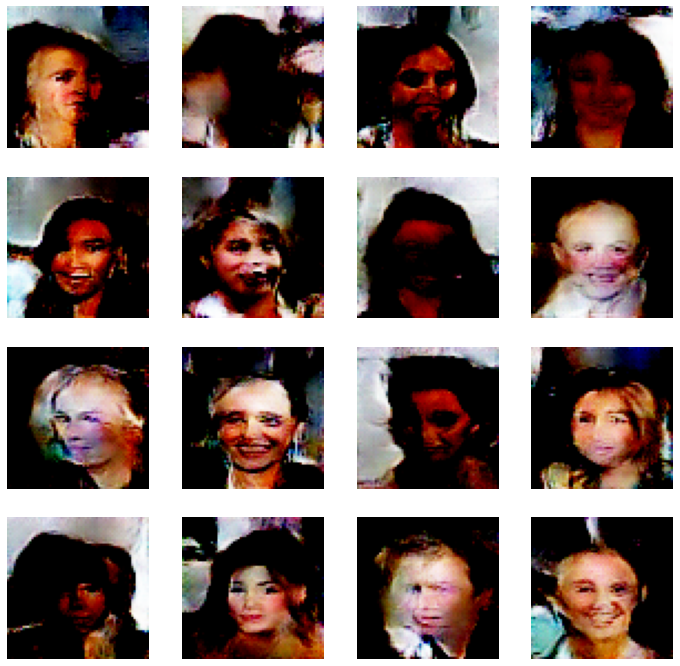

In [40]:
# Function to Display a 4 × 4 image grid showcasing randomly selected images from the directory containing fake images for different models
def display_4x4_images(folder_path, num_rows=4, num_cols=4):
    # Get list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    # Randomly select images from the list
    selected_images = random.sample(image_files, num_rows * num_cols)
    
    # Creating a subplot with the specified number of rows and columns
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
    # Plotting each selected image
    for i, img_file in enumerate(selected_images):
        img_path = os.path.join(folder_path, img_file)
        img = mpimg.imread(img_path)
        row = i // num_cols
        col = i % num_cols
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
    
    # Show the plot
    plt.show()


In [ ]:
# Code to Display a 4 × 4 image grid showcasing randomly selected images from the fake images generated by BCE GAN
folder_path = "./results_DG12/fake_images"
display_4x4_images(folder_path)

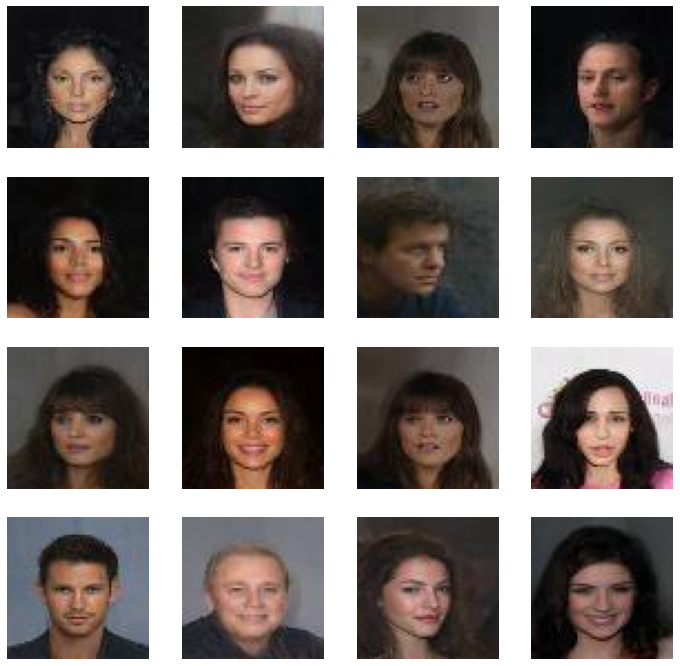

In [41]:
# Code to Display a 4 × 4 image grid showcasing randomly selected images from the fake images generated by Diffusion model
folder_path = "./visualize_samples_celebA12"
display_4x4_images(folder_path)


In [15]:
from pytorch_fid.fid_score import calculate_activation_statistics , calculate_frechet_distance
from pytorch_fid.inception import InceptionV3
# you have to write a script to populate the following path lists

real_dir = "./celebA/0/"
fake_dir = "./results_DG12/fake_images1/"


# Get the list of image files in the directories
real_paths = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if os.path.isfile(os.path.join(real_dir, f))]
fake_paths = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if os.path.isfile(os.path.join(fake_dir, f))]

dims = 2048
block_idx = InceptionV3 . BLOCK_INDEX_BY_DIM [ dims ]
model = InceptionV3 ([ block_idx ]) . to ( device )
m1 , s1 = calculate_activation_statistics (real_paths , model , device = device )
m2 , s2 = calculate_activation_statistics (fake_paths , model , device = device )
fid_value = calculate_frechet_distance ( m1 , s1 , m2 , s2 )
print ( f"FID: { fid_value : .2f}")

100%|██████████| 20/20 [00:01<00:00, 14.82it/s]


FID:  131.34


In [13]:
from pytorch_fid.fid_score import calculate_activation_statistics , calculate_frechet_distance
from pytorch_fid.inception import InceptionV3
# you have to write a script to populate the following path lists


fake_dir = "./visualize_samples_celebA/"
real_dir = "./celebA/0/"

# Get the list of image files in the directories
real_paths = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if os.path.isfile(os.path.join(real_dir, f))]
fake_paths = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if os.path.isfile(os.path.join(fake_dir, f))]

dims = 2048
block_idx = InceptionV3 . BLOCK_INDEX_BY_DIM [ dims ]
model = InceptionV3 ([ block_idx ]) . to ( device )
m1 , s1 = calculate_activation_statistics (real_paths , model , device = device )
m2 , s2 = calculate_activation_statistics (fake_paths , model , device = device )
fid_value = calculate_frechet_distance ( m1 , s1 , m2 , s2 )
print ( f"FID: { fid_value : .2f}")

100%|██████████| 21/21 [00:01<00:00, 11.61it/s]


FID:  69.03
